# Market Basket Analysis

This analysis uses 'Online Retail' data from UCI data collection, and is aimed provide a background on **Apriori algorithm**, and a practical implementation of the same via Python.  

## Primer on Apriori Algorithm & Association Rules
  
Apriori algorithms is a data mining algorithm used for mining **frequent itemsets** and **relevant association rules**. It is devised to operate on a database that contain transactions -like, items bought by a customer in a store. 

An itemset can be considered ***frequent*** if it meets a user-specified support threshold. For example, if the support threshold is set to 0.5(50%), a frequent itemset is a set of items that are bought/purchased together in atleast 50% of all transactions. 

***Association rules*** are a set of rules derived from a database, that can help determining relationship among variables in a large transactional database. 

For example, let I ={i(1),i(2)...,i(m)} be a set of m attributes called items, and T={t(1),t(2),...,t(n)} be the set of transactions. Every transaction t(i) in T has a unique transaction ID, and it contains a subset of itemsets in I.

Association rules are usually written as **i(j) -> i(k)**. This means that there is a strong relationship between the purchase of item i(j) and item i(k). Both these items were purchased together in the same transaction. 
  
In the above example, i(j) is the **antecedent** and i(k) is the **consequent**. 

Please note that both antecedents and consequents can have multiple items. For example, {Diaper,Gum} -> {Beer, Chips} is also valid. 

Since multiplie rules are possible even from a very small database, i-order to select the most relevant ones, we use constraints on various measures of interest. The most important measures are discussed below. They are:

** 1. Support : ** The support of an itemset X, *supp(X)* is the proportion of transaction in the database in which the item X appears. It signifies the popularity of an itemset.

supp(X) = (Number of transactions in which X appears)/(Total number of transactions)
  
We can identify itemsets that have support values beyond this threshold as significant itemsets.  

** 2. Confidence :** Confidence of a rule signifies the likelihood of item Y being purchased when item X is purchased. 

Thus, *conf(X -> Y) = supp(X *U* Y) / supp( X )*

If conf (X -> Y) is 75%, it implies that, for 75% of transactions containing X & Y, this rule is correct. It is more like a conditional probability, P(Y|X), that the probability of finding itemset Y in transactions fiven that the transaction already contains itemset X.
  
  
** 3. Lift :** Lift explains the the likelihood of the itemset Y being purchased when itemset X is already purchased, while taking into account the popularity of Y. 
  
Thus, *lift (X -> Y) = supp (X *U* Y)/( supp(X) * supp (Y) )*

If the value of lift is greater than 1, it means that the itemset Y is likely to be bought with itemset X, while a value less than 1 implies that the itemset Y is unlikely to be bought if the itemset X is bought. 

** 4. Conviction :** The conviction of a rule can be defined as :

*conv (X->Y) = (1-supp(Y))/(1-conf(X-Y))*

If the conviction means 1.4, it means that the rule X -> Y would be incorrect 40% more often if the association between X & Y was an accidental chance.

### Steps in Apriori Algorithm

The steps in implementing Apriori Algorithm are:
  
1. Create a frequency table of all items that occur in all transactions.
  
2. Select only those (significant) items - for which the support is greater than threshold (50%)
  
3. Create possible pairs of all items (remember AB is same as BA)
  
4. Select itemsets that are only significant (support > threshold)

5. Create tiplets using another rule, called self-join. It says, from the item pairs AB, AC, BC, BD, we look for pairs with identical first letter. So we from AB, AC we get ABC. From BC, BD we get BCD.
  
6. Find frequency of the new triplet pairs, and select only those pairs where the support of the new itemset (ABC or BCD) is greater than the threshold.  
  
7. If we get 2 pairs of significant triplets, combine and form groups of 4, repeat the threshold process, and continue.
  
8. Continue till the frequency after grouping is less than threshold support. 

### Pros of Apriori algorithm:

1. Easy to understand and implement
2. Can be used on large itemsets

### Cons of Apriori algoritm

1. Can get compuationally expensive if the candidate rules are large
2. Calculating support is also expensive since it has to go through the whole database

## Code
  
Just as a quick note, this analysis requires all data of a transaction to be included in 1 row, and the items should be 1-hot encoded. Since sklearn doesn't have a direct way to do this, we would be using **MLxtend** library here. 

In [7]:
# code to install any package via python

def install_and_import(package):
    import importlib
    try: 
        importlib.import_module(package)
    except ImportError:
        import pip
        pip.main(['install', package])
    finally:
        globals()[package] = importlib.import_module(package)
        
install_and_import('mlxtend')

Installing packages

In [25]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import pyodbc

In [ ]:
# Import table from SQL Server

In [15]:
Cnt2SQL = pyodbc.connect(
"Driver={SQL Server Native Client 11.0};"
    #REPLACE TCOKER with your own Server Name(you can find the server name on the connect window when you open sql mgt studio)
 "Server=DESKTOP-NEDV4G5;"
    # REPLACE AdventureWorksDW2012 with the database you want
"Database=AdventureWorks2012;"
"Trusted_Connection=yes;")

In [95]:
df = pd.read_sql_query("""
SELECT 
B.[SalesOrderNumber],
C.Name AS Description,
A.[OrderQty],
B.OrderDate,
A.UnitPrice,
[CustomerID],
D.[Name] AS Region,
CASE
     WHEN  D.[Name] = 'Southeast' THEN 'United States of America'
	 WHEN  D.[Name] = 'Northwest' THEN 'United States of America'
	 WHEN  D.[Name] = 'Northeast' THEN 'United States of America'
	 WHEN  D.[Name] = 'Southwest' THEN 'United States of America'
	 WHEN  D.[Name] = 'Australia' THEN 'Australia'
	 WHEN  D.[Name] = 'Canada'    THEN 'Canada'
	 WHEN  D.[Name] = 'Central'   THEN 'United States of America'
	 WHEN  D.[Name] = 'France'    THEN 'France'
	 WHEN  D.[Name] = 'Germany'   THEN 'Germany'
	 WHEN  D.[Name] = 'United Kingdom' THEN 'United Kingdom'
END AS 'Country'

FROM [Sales].[SalesOrderDetail] AS A
LEFT JOIN  [Sales].[SalesOrderHeader] AS B
ON A.SalesOrderID = B.SalesOrderID
LEFT JOIN [Production].[Product] AS C
ON C.ProductID = A.ProductID
LEFT JOIN [Sales].[SalesTerritory] AS D
ON D.TerritoryID = B.TerritoryID
""",Cnt2SQL)

In [96]:
df.head()

,SalesOrderNumber,Description,OrderQty,OrderDate,UnitPrice,CustomerID,Region,Country
0,SO43659,"Mountain-100 Black, 42",1,2011-05-31,2024.994,29825,Southeast,United States of America
1,SO43659,"Mountain-100 Black, 44",3,2011-05-31,2024.994,29825,Southeast,United States of America
2,SO43659,"Mountain-100 Black, 48",1,2011-05-31,2024.994,29825,Southeast,United States of America
3,SO43659,"Mountain-100 Silver, 38",1,2011-05-31,2039.994,29825,Southeast,United States of America
4,SO43659,"Mountain-100 Silver, 42",1,2011-05-31,2039.994,29825,Southeast,United States of America


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 8 columns):
SalesOrderNumber    121317 non-null object
Description         121317 non-null object
OrderQty            121317 non-null int64
OrderDate           121317 non-null datetime64[ns]
UnitPrice           121317 non-null float64
CustomerID          121317 non-null int64
Region              121317 non-null object
Country             121317 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 7.4+ MB


In [98]:
#Name column not needed anymore
df=df.drop(['Region'],axis=1)

In [99]:
df.head()

,SalesOrderNumber,Description,OrderQty,OrderDate,UnitPrice,CustomerID,Country
0,SO43659,"Mountain-100 Black, 42",1,2011-05-31,2024.994,29825,United States of America
1,SO43659,"Mountain-100 Black, 44",3,2011-05-31,2024.994,29825,United States of America
2,SO43659,"Mountain-100 Black, 48",1,2011-05-31,2024.994,29825,United States of America
3,SO43659,"Mountain-100 Silver, 38",1,2011-05-31,2039.994,29825,United States of America
4,SO43659,"Mountain-100 Silver, 42",1,2011-05-31,2039.994,29825,United States of America


In [100]:
#check for missing values
df.isnull().sum()

SalesOrderNumber    0
Description         0
OrderQty            0
OrderDate           0
UnitPrice           0
CustomerID          0
Country             0
dtype: int64

In [101]:
#check if data has refunds
df[df['OrderQty']<0].head()

,SalesOrderNumber,Description,OrderQty,OrderDate,UnitPrice,CustomerID,Country


In [ ]:
dataset = dataset[dataset['Quantity']>0]
dataset.shape

#  Exploratory Data Analysis

- Look at top selling products and plot a graph for better visualization

In [102]:
df['Description'].value_counts().iloc[:10]

Water Bottle - 30 oz.      4688
AWC Logo Cap               3382
Patch Kit/8 Patches        3354
Mountain Tire Tube         3095
Sport-100 Helmet, Blue     3090
Sport-100 Helmet, Red      3083
Sport-100 Helmet, Black    3007
Road Tire Tube             2376
Fender Set - Mountain      2121
Mountain Bottle Cage       2025
Name: Description, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

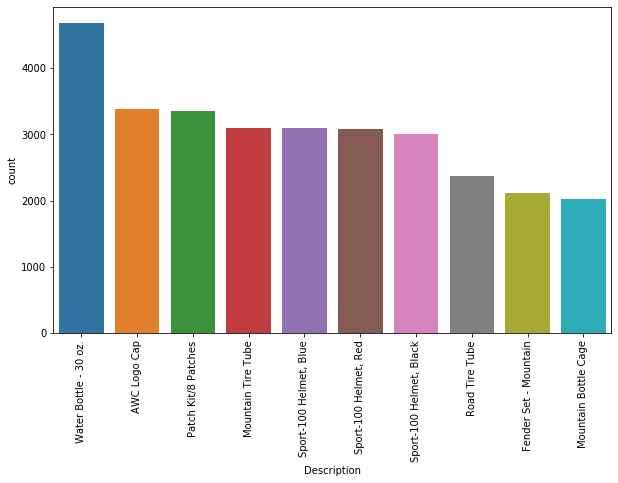

In [103]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'Description', data = df,
              order = df['Description'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)

### Frequency of Most Poplar Products

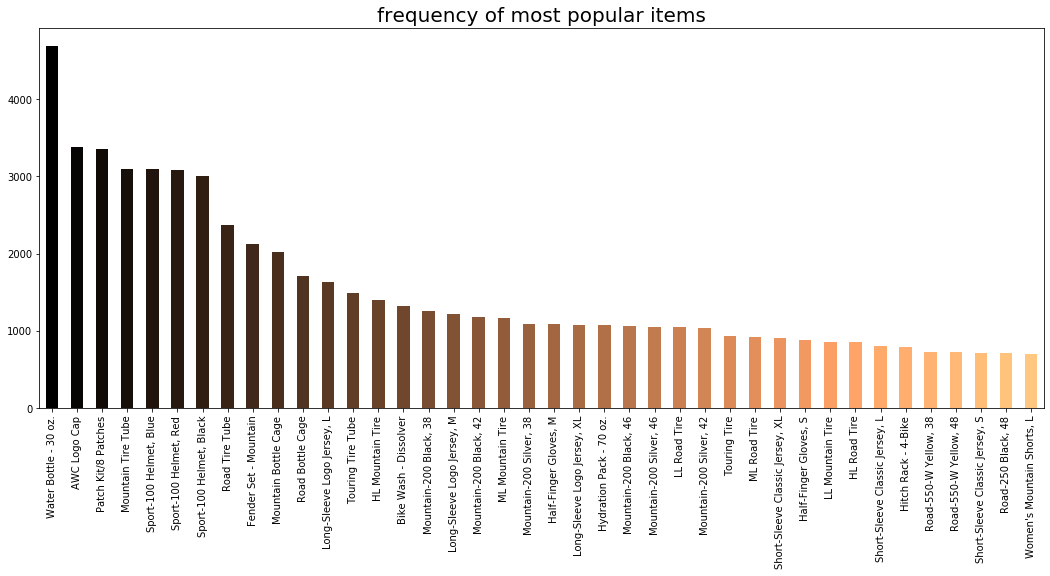

In [104]:
plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 40))
df['Description'].value_counts().head(40).plot.bar(color = color)
plt.title('frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90 )
plt.show()

### Data Distribution By Country

In [105]:
df.groupby('Country').count().reset_index().sort_values('SalesOrderNumber', ascending = False).head(10)

,Country,SalesOrderNumber,Description,OrderQty,OrderDate,UnitPrice,CustomerID
5,United States of America,60153,60153,60153,60153,60153,60153
1,Canada,19064,19064,19064,19064,19064,19064
0,Australia,15058,15058,15058,15058,15058,15058
4,United Kingdom,10426,10426,10426,10426,10426,10426
2,France,9088,9088,9088,9088,9088,9088
3,Germany,7528,7528,7528,7528,7528,7528


- from the table we can see that the largest number of transactions per region is the United States(US)
- not surprisinlgy the US also has the highest number of customers

**1-hot encoding :** This is the process pf consolidating items into one transaction per row.  

This can be done manually like below, or via the mlxtend.
  
The one-hot encoding from *mxltend* encodes transaction data in form of a Python list into a NumPy integer array.  

The colums represent unique items present in the input array, and rows represent the individual transactions. 

Before proceeding with the 1-hot encoding, let us see the number of transactions by country. 

In [112]:
Basket = (df[df['Country'] =="Canada"]
 .pivot_table(index="SalesOrderNumber", columns="Description", values="OrderQty", aggfunc = "sum", fill_value =0))

In [113]:
Basket.head(n=5).T

SalesOrderNumber,SO43661,SO43662,SO43668,SO43672,SO43674
Description,,,,,
AWC Logo Cap,4,0,4,0,0
All-Purpose Bike Stand,0,0,0,0,0
Bike Wash - Dissolver,0,0,0,0,0
Cable Lock,0,0,0,0,0
Chain,0,0,0,0,0
"Classic Vest, L",0,0,0,0,0
"Classic Vest, M",0,0,0,0,0
"Classic Vest, S",0,0,0,0,0
Fender Set - Mountain,0,0,0,0,0


For the sake of this analysis, we will look at the transactions in Canada, and later with UK or France or EIRE to see if there is a difference in product purchase behaviour accross countries. 

In-order to complete the one-hot encoding process, we need to replace all values of quantity >=1 by 1. 

In [115]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
Final_Basket = Basket.applymap(encode_units)

In [116]:
Final_Basket.head()

Description,AWC Logo Cap,All-Purpose Bike Stand,Bike Wash - Dissolver,Cable Lock,Chain,"Classic Vest, L","Classic Vest, M","Classic Vest, S",Fender Set - Mountain,Front Brakes,...,"Touring-3000 Yellow, 54","Touring-3000 Yellow, 58","Touring-3000 Yellow, 62",Water Bottle - 30 oz.,"Women's Mountain Shorts, L","Women's Mountain Shorts, M","Women's Mountain Shorts, S","Women's Tights, L","Women's Tights, M","Women's Tights, S"
SalesOrderNumber,,,,,,,,,,,,,,,,,,,,,
SO43661,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SO43662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SO43668,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SO43672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SO43674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Apriori

**Setting parameters for algorithm**

Minimum Support selected is 6%. You can increase the value to 10% or above for better accuracy however that could end up producing less number of rules

The criteria would be: ** Building frequent products using Apriori and building the rules with association_rules**

To start with and have sufficient data, let us look at frequent itemsets that have a support of atleast 6%.

In [118]:
## Apriori to select the most important itemsets
Frequent_itemsets = apriori(Final_Basket, min_support = 0.06, use_colnames = True)

Frequent_itemsets.sort_values('support', ascending = False).head()

,support,itemsets
11,0.168675,(Water Bottle - 30 oz.)
5,0.159577,(Mountain Tire Tube)
6,0.132530,(Patch Kit/8 Patches)
0,0.119498,(AWC Logo Cap)
8,0.113843,"(Sport-100 Helmet, Black)"


** Association Rules:**

Now since we have identified the key itemsets, let us apply the association rules to learn the purchase behaviours.

Generating rules by lift and confidence

min_threshhold=1 as otherwise the products will be indepedent to other

In [119]:
Asso_Rules = association_rules(Frequent_itemsets, metric = "lift", min_threshold = 1)
Asso_Rules.sort_values('lift',ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Mountain Bottle Cage),(Water Bottle - 30 oz.),0.089009,0.168675,0.075731,0.850829,5.044199,0.060718,5.572959
1,(Water Bottle - 30 oz.),(Mountain Bottle Cage),0.168675,0.089009,0.075731,0.448980,5.044199,0.060718,1.653280


*Explanation*

* Fro first rule, Mountain Bottle Cage => Water Bottle - 30 oz

**Support =7.3%** which means this rule is appearing in 7.5% of the whole dataset

**Confidence =85%** which means both products were bought 85% times ogether if a customer buys Mountain Bottle Cage

**Lift = 5.0** which means the presence of Mountain Bottle Cage in a transaction will increase the probability of having Water Bottle - 30 oz
in the same transaction by 5.0 times 

**Lift formula = support/support(A)*support(B)**

** This analysis was for one country - CANADA **

Now let us see if there are ways we can leverage **popularity** of certain items to drive more sales through Combo offers or so.

In [122]:
Final_Basket['Mountain Bottle Cage'].sum()

362

In [124]:
Final_Basket['Water Bottle - 30 oz.'].sum()

686

From the Canada Sales dataset, the most popular (frequently purhcased) item is Mountain Bottle Cage, followed by Water Bottle - 30 oz.
  
Since both these products are purchased very frequently (as recommended by the association rules), the popularity of the Mountain Bottle Cage can be used to drive sales of Water Bottle - 30 oz. through cobo offers or something. 

** Purchase behaviour in UK:**

In [126]:
Basket_United_Kingdom = (df[df['Country'] =="United Kingdom"]
 .pivot_table(index="SalesOrderNumber", columns="Description", values="OrderQty", aggfunc = "sum", fill_value =0))

def sum_to_boolean(x):
    if x<=0:
        return 0
    else:
        return 1

Basket_Final_United_Kingdom = Basket_United_Kingdom.applymap(sum_to_boolean)
Frequent_itemsets_United_Kingdom = apriori(Basket_Final_United_Kingdom, min_support = 0.06, use_colnames = True)

Asso_Rules_United_Kingdom = association_rules(Frequent_itemsets_United_Kingdom, metric = "lift", min_threshold = 1)
Asso_Rules_United_Kingdom.sort_values('lift',ascending = False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Road Bottle Cage),(Water Bottle - 30 oz.),0.071140,0.163715,0.067102,0.943231,5.761408,0.055455,14.731474
1,(Water Bottle - 30 oz.),(Road Bottle Cage),0.163715,0.071140,0.067102,0.409867,5.761408,0.055455,1.573984


* From first rule, Road Bottle Cage => Water Bottle - 30 oz

**Support =0.06** which means this rule is appearing in 6% of the whole dataset

**Confidence =94%** which means both products were bought 94% times ogether if a customer buys Road Bottle Cage

**Lift = 5.7** which means the presence of Road Bottle Cage in a transaction will increase the probability of having Water Bottle - 30 oz
in the same transaction by 5.7 times 

**Building rules by playing around with a higher lift and confidence level**

Pandas dataframes make it easy to filter the results further. Lets set the new rules by setting following parameters:

1. at least 2 antecedents
2. a confidence level of over 75%
3. a lift score of voer 1.2

In [ ]:
rules['antecedent_len'] = rules['antecedents'].apply(lambda x:len(x))
rules

In [ ]:
rules[ (rules['antecedent_len'] >= 1) &
       (rules['confidence'] > 0.75) &
       (rules['lift'] > 1.2) ]